In [1]:
using Distributions
using Random
using scBayesDeconv
using Plots
using MAT
using Statistics

In [2]:
fitca = matread("Data/Real_1_multichannel/20191030_FITCA.mat")
percp = matread("Data/Real_1_multichannel/20191030_PerCP-Cy5-5-A.mat")

Dict{String, Any} with 3 entries:
  "intensity"        => [244.53 306.9 … 293.04 203.94; 57.42 345.51 … 407.88 33…
  "Conditions"       => Any["20191030-1_Bra Act+Chi_P3" "20191030-1_Bra Act_P3"…
  "intensity_pulled" => [244.53 306.9 … 12.87 297.99; 57.42 345.51 … 297.0 97.0…

In [3]:
channel1 = fitca["intensity"][:,1]
channel1c = fitca["intensity"][:,7]
channel2 = percp["intensity"][:,1]
channel2c = percp["intensity"][:,7];

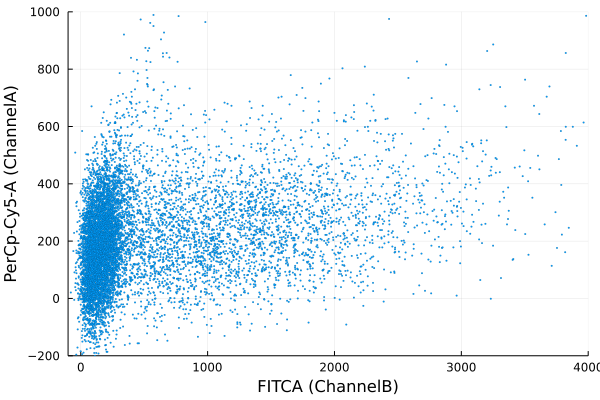

In [4]:
scatter(channel1,channel2,markersize=1,markerstrokewidth=0.1,xlabel="FITCA (ChannelB)",ylabel="PerCp-Cy5-A (ChannelA)",label="")
xlims!(-100,4000)
ylims!(-200,1000)

In [16]:
n = channel2[1:3000]
t = channel1[1:3000]
c = channel1c[1:3000]+channel2c[1:3000];

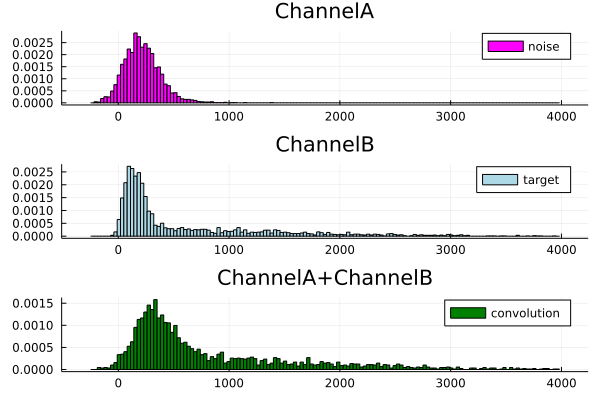

In [17]:
bins = range(-250,4000,step=30)
l1 = histogram(n,normalize=true,bins=bins,label="noise",title="ChannelA",color="magenta")

bins = range(-250,4000,step=30)
l2 = histogram(t,normalize=true,bins=bins,label="target",title="ChannelB",color="lightblue")

bins = range(-250,4000,step=30)
l3 = histogram(c,normalize=true,bins=bins,label="convolution",title="ChannelA+ChannelB",color="green")

plot(l1,l2,l3,layout=(3,1))

In [18]:
dn = infiniteGaussianMixture(reshape(n,length(n),1),k=2,κ0=0.01);

In [19]:
dtfitted = infiniteGaussianMixture(reshape(t,length(t),1),k=2,κ0=0.01);

In [20]:
dc = infiniteGaussianMixture(reshape(c,length(c),1),k=2,κ0=0.01);

In [21]:
dt = infiniteGaussianMixtureDeconvolution(reshape(c,length(c),1),dn,Σ0=1500*ones(1,1),k=10,κ0=0.01,ν0=0.01,α=1);

In [22]:
x = -200:10:5000
bins = range(-250,5000,step=30)

#Noise
l1 = histogram(vec(n),normalize=true,bins=bins,label="noise",title="ChannelA (Noise)",color="magenta")
y = zeros(99,length(x))
yaux = pdf(dn.samples[1],reshape(x,1,length(x)))[:,1]
plot!(l1,x,yaux,label="Bayesian samples",color="red",alpha=.2)
for k in 2:100
    yaux = pdf(dn.samples[k],reshape(x,1,length(x)))[:,1]
    plot!(l1,x,yaux,label=nothing,color="red",alpha=.2)
    y[k-1,:] = yaux
end
plot!(l1,x,mean(y,dims=1)[1,:],label="Bayesian mean fitted",color="black",legendfontsize=8)

#Target
l2 = histogram(vec(t),normalize=true,bins=bins,label="target",title="ChannelB (Target)",color="green")
y = zeros(99,length(x))
yaux = pdf(dt.samples[1],reshape(x,1,length(x)))[:,1]
plot!(l2,x,yaux,label="Bayesian samples",color="red",alpha=.2)
for k in 2:100
    yaux = pdf(dt.samples[k],reshape(x,1,length(x)))[:,1]
    plot!(l2,x,yaux,label=nothing,color="red",alpha=.2)
    y[k-1,:] = yaux
end
plot!(l2,x,mean(y,dims=1)[1,:],label="Bayesian mean deconv.",color="black",legendfontsize=8)
ylims!(0,.003)

#Convolution
l3 = histogram(c,normalize=true,bins=bins,label="convolution",title=string("ChannelA+ChannelB (Convolution)"),color="lightblue")
y = zeros(99,length(x))
yaux = pdf(scBayesDeconv.sample(dt,distribution=:Convolution),reshape(x,1,length(x)))[:,1]
plot!(l3,x,yaux,label="Bayesian samples",color="red",alpha=.2)
for k in 2:100
    yaux = pdf(scBayesDeconv.sample(dt,distribution=:Convolution),reshape(x,1,length(x)))[:,1]
    plot!(l3,x,yaux,label=nothing,color="red",alpha=.2)
    y[k-1,:] = yaux
end
plot!(l3,x,mean(y,dims=1)[1,:],label="Bayesian mean deconv.",color="black",legendfontsize=8)

plot(l1,l3,l2,layout=(3,1),size=[2000,1000])

In [24]:
println("MIO deconvolution: ",mean(scBayesDeconv.metrics.mio(dt,dtfitted,box=[-200 5000],d=10)))
println("MIO noise: ",mean(scBayesDeconv.metrics.mio(dt,dn,box=[-200 5000],d=10)))
println("MIO convolution: ",mean(scBayesDeconv.metrics.mio(dt,dc,box=[-200 5000],d=10)))

MIO deconvolution: 0.8648220354071815
MIO noise: 0.6542385991926257
MIO convolution: 0.6843923933828983
